# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


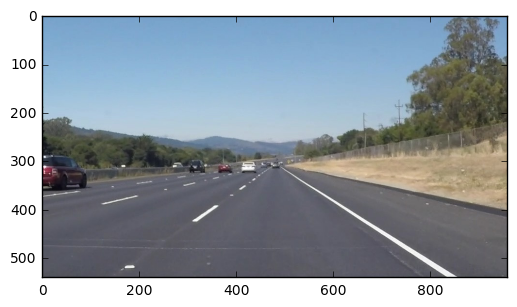

In [8]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [9]:
import math

# Enable drawing some extra things in the output images to help debugging the algorithm
debug=False

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_all_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    if debug:
        draw_all_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [10]:


def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    Here I'm applying a couple of the suggested techniques, first I split the lines into
    left and right according to their slopes, then and to iterate only once, I take a moving
    average of the slopes and discard the lines with a slope outside of the average.
    I tried both including all lines into the average and only the ones passing the slope
    average test, and including everything seems to work better.
    """
    lSlopeAvg=0
    rSlopeAvg=0
    slope_tolerance=.1
    slope_tolerance_from_zero=.5
    top_y = 330
    bottom_y = img.shape[1]
    lLines = []
    rLines = []
    l = 1
    r = 1
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y2-y1)/(x2-x1)
            # Not much choice but to get rid of these lines, unless the car was looking straight into
            # the line it won't have any major influence in the result
            if np.absolute(slope) == np.inf or np.absolute(slope) < slope_tolerance_from_zero:
                continue
            if slope < 0:
                lSlopeAvg = lSlopeAvg + (slope - lSlopeAvg) / l
                l += 1
                if np.absolute(lSlopeAvg - slope) < slope_tolerance :
                    lLines.append((x1,y1))
                    lLines.append((x2,y2))
            else:
                rSlopeAvg = rSlopeAvg + (slope - rSlopeAvg) / r
                r += 1
                if np.absolute(rSlopeAvg - slope) < slope_tolerance :
                    rLines.append((x1,y1))
                    rLines.append((x2,y2))
    
    """
    After having split the lines, I use cv2.fitline to fit the sets of points to a single line.
    cv2.fitline gives back a unit vector and a point in the line, both of which we can use
    to calculate the slope and intercept of the line function.
    """
    [left_vx,left_vy,left_x,left_y] = cv2.fitLine(np.array(lLines, dtype=np.int32), cv2.DIST_L2,0,0.01,0.01)      
    left_slope = left_vy / left_vx
    left_b = left_y - (left_slope*left_x)
   
    [right_vx,right_vy,right_x,right_y] = cv2.fitLine(np.array(rLines, dtype=np.int32), cv2.DIST_L2,0,0.01,0.01)    
    right_slope = right_vy / right_vx
    right_b = right_y - (right_slope*right_x)

    """
    Having the slope and intercept enables us to calculate the x coordinates of our desired
    start and end points at the top and the bottom of the road.
    """
    ltop_x = (top_y - left_b) / left_slope
    lbottom_x = (bottom_y - left_b) / left_slope
    
    rtop_x = (top_y - right_b) / right_slope
    rbottom_x = (bottom_y - right_b) / right_slope
    
    cv2.line(img, (lbottom_x, bottom_y), (ltop_x, top_y), color, thickness)
    cv2.line(img, (rbottom_x, bottom_y), (rtop_x, top_y), color, thickness)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

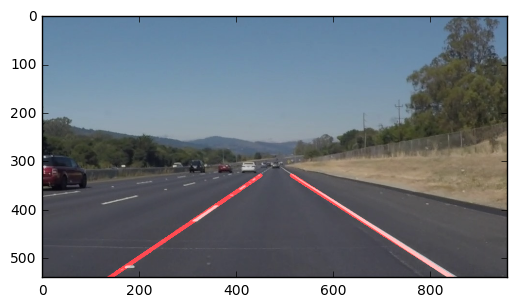

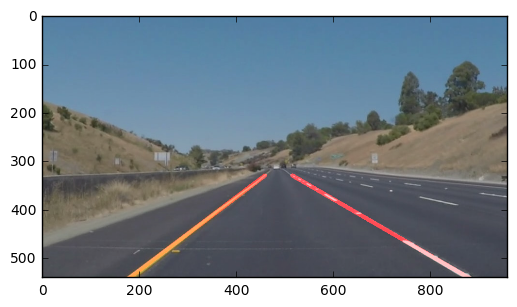

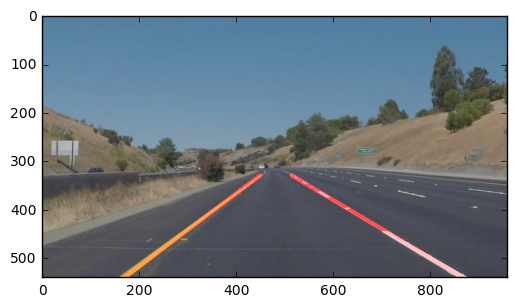

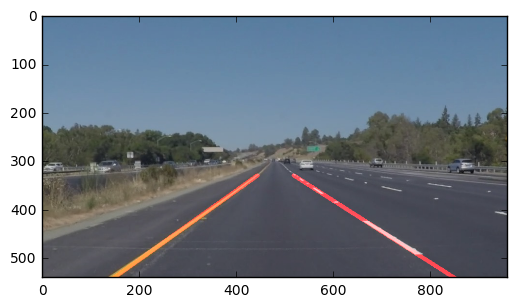

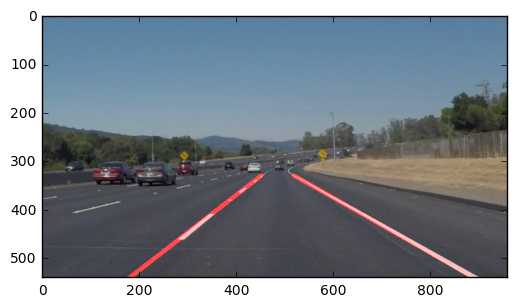

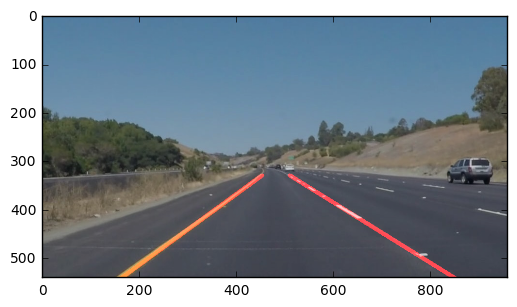

In [11]:
import os
folder = "test_images/"
images = os.listdir(folder)

roi_vertices = np.array([[(110, 540), (420, 340), (960-420,340),(960-40,540)]], dtype=np.int32)
canny_l_threshold = 100
canny_h_threshold = 250

rho=1
theta=np.pi/180
threshold=15
min_line_len=10
max_line_gap=10

def pipeline(image):
    # First of all, convert to grayscale to reduce color information
    gray = grayscale(image)
    # Now, run Canny edge detection
    edges = canny(gray, canny_l_threshold, canny_h_threshold)
    # Then focus on our region of interest
    roi = region_of_interest(edges, roi_vertices)
    
    # Once we have the Canny edges it's turn to run Hough transform
    # and try to find the lines
    lines = hough_lines(roi,rho, theta, threshold, min_line_len, max_line_gap)
        
    # Overlay the Hough lines into the original image
    if debug: 
        return region_of_interest(weighted_img(lines, image),roi_vertices)
    else:
        return weighted_img(lines, image)
       

for imageFile in images:
    original_filename, ext = os.path.splitext(imageFile)
    if ext != ".jpg":
        continue
        
    image = mpimg.imread(folder + imageFile)
    output = pipeline(image)
    
    plt.figure()
    plt.imshow(output, cmap='Greys_r')
    
    new_filename = os.path.join(folder+ "out/", original_filename + "_out" + ext)
    mpimg.imsave(new_filename, output, cmap='Greys_r')

    

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = pipeline(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [14]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 85.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 1.26 s, sys: 108 ms, total: 1.37 s
Wall time: 2.98 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:10<00:00, 51.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 3.99 s, sys: 300 ms, total: 4.29 s
Wall time: 11.3 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Though I'm happy with the results I have so far, there are many possible ways to improve my pipeline. Much of the effort is applied to ignoring the noise, which appears in the image as objects in the ground, horizontal lines pieces of dirt on the road, or mere shadows. Hence why I'm using averaging on the slopes and leaving out lines with odd slopes relative to the ones we're searching for.
One step that could be applied quickly is to average the results between frames. It is expected that the location and direction of the lines in successive frames shouldn't change a huge amount, so averaging their values could help stabilize the detection.
Other reason for our algorithm to possibly fail are low visibility conditions, where it is possible not enough lines are obtained from the Hough transform to determine the correct location of the lines. Another challenge presents when the car switches lanes or turns, because our pipeline assumes two lines on the left and the right.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [18]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 33.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 3.15 s, sys: 252 ms, total: 3.4 s
Wall time: 8.22 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

#Notes
The challenge video presents a different resolution, so the region of interest polygon is off now. An solution to this would be to use adaptable coordinates according to the size of the image.
Also lanes in this video are not lines but since the car is in the middle of a turn, they are curved shapes. And to finish off, there are shadows presenting in the road.